# Goal
We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank. <br>
Build a model with the maximum possible F1 score. 

# Project instructions
1. [x] **Chapter 1** Download and prepare the data. Explain the procedure.
2. [x] **Chapter 2** Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.
3. [x] **Chapter 3** Improve the quality of the model. Make sure you use at least two approaches to fixing class imbalance. Use the training set to pick the best parameters. Train different models on training and validation sets. Find the best one. Briefly describe your findings.
4. [x] **Chapter 4** Perform the final testing.

This <span style="color:red">word</span> is not black.

# Project evaluation
- How did you prepare the data for training? Have you processed all of the feature types?
- Have you explained the preprocessing steps well enough?
- How did you investigate the balance of classes?
- Did you study the model without taking into account the imbalance of classes?
- What are your findings about the task research?
- Have you correctly split the data into sets?
- How have you worked with the imbalance of classes?
- Did you use at least two techniques for imbalance fixing?
- Have you performed the model training, validation, and final testing correctly?
- How high is your F1 score?
- Did you examine the AUC-ROC values?
- Have you kept to the project structure and kept the code neat?

In [210]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.utils import shuffle

# Chapter 1
<font size="3">**Download and prepare the data. Explain the procedure.**</font> 

In [149]:
# import data
df = pd.read_csv('/datasets/Churn.csv')

In [150]:
# look through the table to make sure that it is imported correctly
print(df.shape)
df.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Notice:** <br>
1. *RowNumber* doesn't contain important information that can be used to predict target. We can only check if there are  dublicates in the table (low probability).
2. The same thing we can say about *CustomerId*.
3. It is logical to assume that *Surname* can't influence on target prediction. There could be a low chance to influence on predicted value... if one family member have already exited bank and then the other family member want to exit (low probability).

In [151]:
# check if there any duplicates in data
print('Number of unique values in column _RowNumber_:',len(df.RowNumber.unique()))

Number of unique values in column _RowNumber_: 10000


In [152]:
# check if there any duplicates in data
print('Number of unique values in column _CustomerId_:',len(df.CustomerId.unique()))

Number of unique values in column _CustomerId_: 10000


**so...** as it was expected there are no duplicates <br>
And we can just drop these columns (not use them as features)

In [153]:
# look through the table check types and NA-values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Notice:** <br>
1. All columns have the type as it should be. That is good!
2. Only in *Tenure* there is less than 10 000 significant (not NA) rows. That is good!
3. ~1000 NA-values in *Tenure*. It is ~10% of data. It is too much. So we should fill NA 

In [154]:
# check unique values
np.sort(df.Tenure.unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

**Notice:** <br>
1. As I understand 0-value in *Tenure* means that a person is a client of the bank less than 1 year. So, it is meaningfull.
2. Nan-value is here as we see previously.
3. There are two ways to fill this NA-values: (1) find some correlation and fillna with mean or median values or (2) just make a new cathegory. The last one is not so good because the **order** is important.

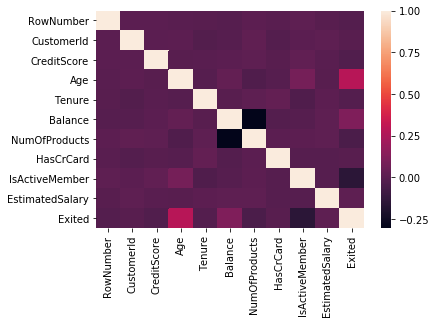

In [155]:
# build heat correlation map
sns.heatmap(df.corr(), 
        xticklabels=df.corr().columns,
        yticklabels=df.corr().columns)

**Notice:** <br>
1. There is a high correlation between *Age* and target value *Exited*.
2. What about *Tenure*.. it is hard to say somethimg from this map.

In [156]:
# find concrete values on correlation; remove selfcorrelation; absolute values; print in ascending order 
abs(df.corr().Tenure).sort_values()[0:10]

CreditScore        0.000062
RowNumber          0.007322
Balance            0.007911
EstimatedSalary    0.010520
NumOfProducts      0.011979
Age                0.013134
Exited             0.016761
CustomerId         0.021418
HasCrCard          0.027232
IsActiveMember     0.032178
Name: Tenure, dtype: float64

**So...** Corelations are extremely low. Even that *IsActiveMember* is the best from the outsiders, we can't use it to restore missing values in *Tenure*. <br>
One can see that even randomness *CustomerId* has close value of correlation. <br>
Let's use *Age* to restore *Tenure* but not as itself. We classify it in ages and than in each class find median value. Why not? It is not a very good idea. But it is not bad too.

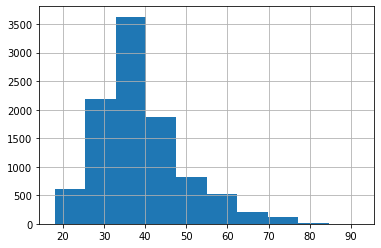

In [157]:
# let's take a look on *Age* data
df.Age.hist()

**So...** I could find boundaries of groups manually BUT I think it is better do it more strictly <br>
I think it is better group by quantile, because in each group we will have the same number of people. There will not be group with extremely low number of people.

In [158]:
# create new column Age_categories  

# determine boundaries as quantile 20%
age_boundaries = []
for share in np.arange(0.2, 1, 0.2):
    age_boundaries.append(df.Age.quantile(share))
age_boundaries.append(max(df.Age))

name_age_group = ['Forever young',
                    'Young',
                    'Helthy',
                    'Wizard',
                    'Master Yoda']

# create new column: apply
def age_categories(row):
    age_k = 0
    for age in age_boundaries:
        if row.Age <= age:
            return name_age_group[age_k]
        else:
            age_k += 1
            
df['Age_group'] = df.apply(age_categories, axis=1)
print(age_boundaries)
print(name_age_group)

[31.0, 35.0, 40.0, 46.0, 92]
['Forever young', 'Young', 'Helthy', 'Wizard', 'Master Yoda']


In [159]:
# groupby:
age_group_median = df.groupby('Age_group').agg({'Tenure': ['median']})
age_group_median.columns = ['median']
print(age_group_median['median'].sort_values())

Age_group
Forever young    5.0
Helthy           5.0
Master Yoda      5.0
Wizard           5.0
Young            5.0
Name: median, dtype: float64


**Hah...** When correletion so low, in each group *Tenure* values distributed chaotically

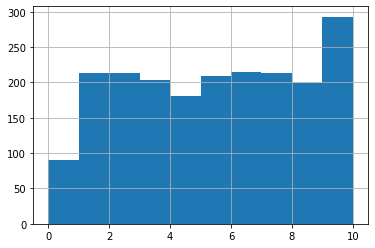

In [160]:
# one can see it
df.query('Age_group == "Helthy"')['Tenure'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7199ac410>,
      dtype=object)

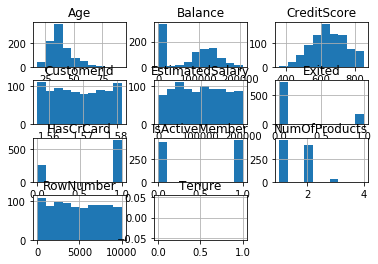

In [161]:
df.query('Tenure.isnull() == True').hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7194db790>,
      dtype=object)

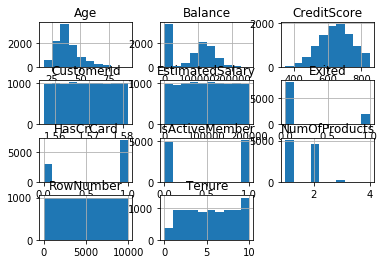

In [162]:
df.hist()

**So...** I really don't see any connection this parameter with others. If we groupby data by another parameter we obtain the similar result. <br>
I prefer drop off these NA-values. If I assing to NA-values some value randomly it just add a noise to our  dataframe. <br>
The other way is to drop off the column itself (not use it as a feature). But I prefer the first way.

In [163]:
df_drop = df.dropna()
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 15 columns):
RowNumber          9091 non-null int64
CustomerId         9091 non-null int64
Surname            9091 non-null object
CreditScore        9091 non-null int64
Geography          9091 non-null object
Gender             9091 non-null object
Age                9091 non-null int64
Tenure             9091 non-null float64
Balance            9091 non-null float64
NumOfProducts      9091 non-null int64
HasCrCard          9091 non-null int64
IsActiveMember     9091 non-null int64
EstimatedSalary    9091 non-null float64
Exited             9091 non-null int64
Age_group          9091 non-null object
dtypes: float64(3), int64(8), object(4)
memory usage: 1.1+ MB


In [164]:
# about Surname column
print('There are',len(df_drop['Surname'].unique()), 'unique values in Surname')

There are 2787 unique values in Surname


**I think..**
1. *Surname* shouldn't influence on target value
2. If I apply OHE to *Surname* I get 2786 of new columns-features. I think it is challenging for our model and unecessary. There are more cons than pros.

**-OHE-**
We discussed already what we will use as features (what to drop) <br>
So.. we should prepare only categorical columns *Gender* and *Geography*.

In [165]:
data_OHE = pd.get_dummies(df_drop, columns=['Gender','Geography'], drop_first=True)

### Result of chapter 1
Data is prepared to use it to train a model. <br>
DROP: RowNumber	CustomerId	Surname
OHE: Geography	Gender	
AS IS: CreditScore	Age	Tenure	Balance	NumOfProducts	HasCrCard	IsActiveMember	EstimatedSalary	Exited

# Chapter 2
<font size="3">**Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.**</font> 

In [166]:
# determine features and target
features = data_OHE.drop(['Exited', 'RowNumber', 'CustomerId','Surname','Age_group'], axis=1)
target = data_OHE['Exited']

# split dataset on training and validation+test sets
features_train, features_valid, target_train, target_valid = train_test_split(
                    features, target, test_size=0.40, random_state=10)

# split dataset on validation and test sets
features_test, features_valid, target_test, target_valid = train_test_split(
                    features_valid, target_valid, test_size=0.50, random_state=10)

In [167]:
# check balance of target feature
print('Share of exited clients: {:.0%}'.format(target.sum()/len(target)))

# note that in the original set of data there is the same share of exited clients
print('Share of exited clients in original dataframe: {:.0%}'.format(df['Exited'].sum()/len(df)))

Share of exited clients: 20%
Share of exited clients in original dataframe: 20%


**Notice:** <br>
1. That means that target feature is unbalanced. <br>
2. It is easy to proceed **sanity check**: if we predict directly only zeros, than our model will be correct (accuracy) in 80% of cases.<br>
3. But we need maximize f1, in that case f1 is 0%. So we need model better than 0%<br>
4. **Globally** we solve a binary classification problem (1 - exited; 0 - stayed). <br>
That's why we can use: *DecisionTreeClassifier, RandomForestClassifier* and *LogisticRegression*

**Train the model without taking into account the imbalance.**

In [168]:
# train linear model (I choose it in this task)
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [169]:
# this is a function to print scores
def print_scores(features_train, features_valid, target_train, target_valid):
    predicted_train = model.predict(features_train)
    predicted_valid = model.predict(features_valid)
    print('             Accuracy: Precision: Recall:  F1:')
    print('Train set:      {:.2%} {:.2%}     {:.2%}   {:.2%}'.format(
                                        accuracy_score(target_train, predicted_train),
                                        precision_score(target_train, predicted_train),
                                        recall_score(target_train, predicted_train),
                                        f1_score(target_train, predicted_train)))
    print('Validation set: {:.2%} {:.2%}     {:.2%}   {:.2%}'.format(
                                        accuracy_score(target_valid, predicted_valid),
                                        precision_score(target_valid, predicted_valid),
                                        recall_score(target_valid, predicted_valid),
                                        f1_score(target_valid, predicted_valid)))

In [170]:
print_scores(features_train, features_valid, target_train, target_valid)

             Accuracy: Precision: Recall:  F1:
Train set:      79.01% 40.38%     5.65%   9.91%
Validation set: 78.06% 46.00%     5.82%   10.34%


**So...**<br>
1. F1 is extremly low 10%!
2. Accuracy ... 79% in the level of sanity check. Happy not to use this metric.

In [171]:
# train decision tree model
model = DecisionTreeClassifier(max_depth=3, random_state=12345)
model.fit(features_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

In [172]:
print_scores(features_train, features_valid, target_train, target_valid)

             Accuracy: Precision: Recall:  F1:
Train set:      84.32% 85.71%     27.98%   42.19%
Validation set: 83.29% 85.27%     27.85%   41.98%


**So...**<br>
1. F1 become better 41%!
2. Accuracy is better 83.3%.

In [173]:
# train decision tree model
model = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=12345)
model.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [174]:
print_scores(features_train, features_valid, target_train, target_valid)

             Accuracy: Precision: Recall:  F1:
Train set:      85.85% 88.37%     35.43%   50.58%
Validation set: 83.51% 81.46%     31.14%   45.05%


**So...**<br>
1. F1 become even better 45%!
2. Accuracy even better 83.5%.

### Results of chapter 2
1. Target is not balanced 80%/20% (zero/one)
2. I apply 3 models without any tuning to estimate the quality of predicition.
3. I checked 3 metrics: accuracy, recall, precision (+f1) to estimate quality. This not good preliminary study showed that Random forest here is the best

# Chapter 3
<font size="3">**Improve the quality of the model. Make sure you use at least two approaches to fixing class imbalance. Use the training set to pick the best parameters. Train different models on training and validation sets. Find the best one. Briefly describe your findings.**</font> 

<font size="3">**Consider balance-problem**</font> 

<font size="3">*1st technique: class_weight = balanced*</font>

In [175]:
# train random forest model
model = RandomForestClassifier(n_estimators=150, max_depth=5, class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

In [176]:
print_scores(features_train, features_valid, target_train, target_valid)

             Accuracy: Precision: Recall:  F1:
Train set:      80.80% 52.18%     73.09%   60.89%
Validation set: 77.63% 48.90%     67.59%   56.75%


**So...**<br>
1. F1 after balance become 56%! And we haven't tuning our model yet.
2. Accuracy in the level of sanity check.

<font size="3">*2nd technique: upsampling*</font>

In [177]:
# use function for upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
                        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# apply it on train set
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [178]:
print('1-values in data:',len(features_upsampled[target == 0]))
print('0-values in data:',len(features_upsampled[target == 1]))

1-values in data: 4339
0-values in data: 4460


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [179]:
# train random forest model
model = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=12345)
model.fit(features_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [180]:
print_scores(features_upsampled, features_valid, target_upsampled, target_valid)

             Accuracy: Precision: Recall:  F1:
Train set:      78.40% 80.87%     75.16%   77.91%
Validation set: 77.19% 48.25%     69.62%   56.99%


**So...**<br>
1. F1 after upsampling become 57%. It gives better result on training set, but on validation set it is near the same 56.99% (before 56.75%).
2. We have good recall score 70% and still low precision.

<font size="3">**Choose best model with balanced dataset**</font> 

<font size="3">*Random Forest (upsampled)*</font>

In [181]:
# train random forest model and find best parameters
# we save all calculated results in list f1_scores_res [[max_depth, n_estimators, f1_score]_i...]
f1_scores_res = []
for mdepth in range(1,10):
    for nestimat in range (30,220,30):
        model = RandomForestClassifier(n_estimators=nestimat, max_depth=mdepth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        
        predicted_valid = model.predict(features_valid)
        f1_scores_res.append([mdepth, nestimat, f1_score(target_valid, predicted_valid)])

In [182]:
# find from the list maximal f1_score
f1_best = max([row[2] for row in f1_scores_res])

# find corresponding max_depth and n_estimators 
max_depthB, n_estimatosB = [ [row[0],row[1]]  for row in f1_scores_res if row[2] == f1_best][0]
print('max_depth =',max_depthB, 'n_estimator =',n_estimatosB)

max_depth = 9 n_estimator = 30


In [183]:
model = RandomForestClassifier(n_estimators=n_estimatosB, max_depth=max_depthB, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid) 
print_scores(features_upsampled, features_valid, target_upsampled, target_valid)

             Accuracy: Precision: Recall:  F1:
Train set:      87.28% 88.93%     85.56%   87.21%
Validation set: 80.54% 54.18%     67.34%   60.05%


**So...**<br>
1. F1 after upsampling + random forest with best parameters give **60%**! (train set: 87%)
2. Could the difference between F1 on train set and validation set show us that it is overtraining?

<font size="3">*Random Forest (class_weight)*</font>

In [218]:
# train random forest model and find best parameters
# we save all calculated results in list f1_scores_res [[max_depth, n_estimators, f1_score]_i...]
f1_scores_res = []
for mdepth in range(1,10):
    for nestimat in range (30,220,30):
        model = RandomForestClassifier(n_estimators=nestimat, max_depth=mdepth, class_weight='balanced', random_state=12345)
        model.fit(features_train, target_train)
        
        predicted_valid = model.predict(features_valid)
        f1_scores_res.append([mdepth, nestimat, f1_score(target_valid, predicted_valid)])

In [219]:
# find from the list maximal f1_score
f1_best = max([row[2] for row in f1_scores_res])

# find corresponding max_depth and n_estimators 
max_depthBfor, n_estimatosBfor = [ [row[0],row[1]]  for row in f1_scores_res if row[2] == f1_best][0]
print('max_depth =',max_depthBfor, 'n_estimator =',n_estimatosBfor)

max_depth = 9 n_estimator = 30


In [221]:
model = RandomForestClassifier(n_estimators=n_estimatosBfor, max_depth=max_depthBfor, 
                               class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid) 
print_scores(features_train, features_valid, target_train, target_valid)

             Accuracy: Precision: Recall:  F1:
Train set:      89.53% 71.25%     81.79%   76.16%
Validation set: 82.35% 58.69%     63.29%   60.90%


**So...**<br>
1. F1 after upsampling + random forest with best parameters give **60.9%**! (train set: 76%)

<font size="3">*ROC-AUC: Random Forest (class_weight)*</font>

In [222]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

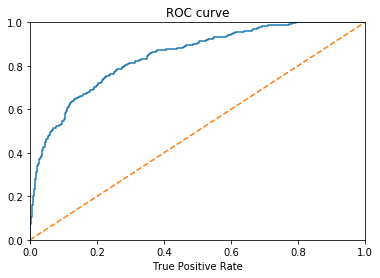

In [223]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

# plot the graph
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC curve")
plt.show()

In [224]:
print('roc_auc_score: {:.0%}'.format(roc_auc_score(target_valid, probabilities_one_valid)))

roc_auc_score: 84%


<font size="3">*Decision Tree*</font>

In [225]:
# train random forest model and find best parameters
# we save all calculated results in list f1_scores_res [[max_depth, n_estimators, f1_score]_i...]
f1_scores_res = []
for mdepth in range(1,10):
    model = DecisionTreeClassifier(max_depth=mdepth, class_weight='balanced', random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)        
    f1_scores_res.append([mdepth, f1_score(target_valid, predicted_valid)])

In [226]:
# find from the list maximal f1_score
f1_best = max([row[1] for row in f1_scores_res])

# find corresponding max_depth and n_estimators 
max_depthB = [ [row[0]]  for row in f1_scores_res if row[1] == f1_best][0]
print('max_depth =',max_depthB)

max_depth = [6]


In [227]:
model = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid) 
print_scores(features_train, features_valid, target_train, target_valid)

             Accuracy: Precision: Recall:  F1:
Train set:      78.71% 48.75%     80.36%   60.68%
Validation set: 75.10% 45.54%     74.94%   56.65%


**So...**<br>
1. F1 after upsampling + tree decision with best parameters give **56.6%**! (train set: 60%)
2. It is not bad but it worse than random forest (random forest: 60.9%)

### Results of chapter3
1. Solved problem with unbalanced data (upsampling + class_weight)
2. I apply 2 models (Random forest and DecisionTree) and tune parameters.
3. The best result for validation set is F1_score = 60.9%.

# Chapter 4
<font size="3">**Perform the final testing.**</font> 

In [228]:
model = RandomForestClassifier(n_estimators=n_estimatosBfor, max_depth=max_depthBfor, class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid) 
print_scores(features_train, features_valid, target_train, target_valid)

             Accuracy: Precision: Recall:  F1:
Train set:      89.53% 71.25%     81.79%   76.16%
Validation set: 82.35% 58.69%     63.29%   60.90%


In [234]:
predicted_test = model.predict(features_test) 
print('{:.1%}'.format(f1_score(target_test, predicted_test)))
#print_scores(features_valid, features_test, target_valid, target_test)

60.2%


# Conclusion
1. We us F1 as a clue metric.
2. The best model is a Random forest with max_depth = 9 n_estimator = 30
3. Balance the data with class_weight is realle matter in this problem
4. The result of testing the model gives f1_score = 60%. In fact it is not so good. We found 63% of those who can exit the bank (recall 63%) and do a lot of wrong decisions (Precision = 58%)

I think that we can do our model better if we increase weight of *Age*. We say that it gives the best correlation.
Hope to see your comments, because this is the first really not easy project.